In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ticker = "^GSPC"  # S&P500
data = yf.download(ticker, start="2000-01-01")
print(data.columns)

prices = data["Close"]["^GSPC"]
log_returns = np.log(prices / prices.shift(1)).dropna()

print("Total observations:", len(log_returns))
log_returns.head()

split_ratio = 0.8
split_index = int(len(log_returns) * split_ratio)

train_series = log_returns[:split_index]
test_series = log_returns[split_index:]

print("Train size:", len(train_series))
print("Test size:", len(test_series))

[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])
Total observations: 6572
Train size: 5257
Test size: 1315


In [7]:
def create_sequence(series,window_size):
    x = []
    y = []
    
    for i in range(len(series)- window_size):
        x.append(series.iloc[i:i+window_size].values)
        y.append(series.iloc[i+window_size])

    return np.array(x), np.array(y)

L = 20

X_train, y_train = create_sequence(train_series, L)
X_test, y_test = create_sequence(test_series,L)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5237, 20)
y_train shape: (5237,)
X_test shape: (1295, 20)
y_test shape: (1295,)


In [8]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5237, 20, 1)
X_test shape: (1295, 20, 1)


In [9]:
import torch

# conversione a float32
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("X_train tensor shape:", X_train_tensor.shape)
print("y_train tensor shape:", y_train_tensor.shape)

X_train tensor shape: torch.Size([5237, 20, 1])
y_train tensor shape: torch.Size([5237])


In [13]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super().__init__()

        self.lstm=nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # prendiamo l'ultimo timestep
        last_output = lstm_out[:,-1,:]

        out = self.fc(last_output)
        return out
    
model = LSTMModel()
print(model)

LSTMModel(
  (lstm): LSTM(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# reshape temporaneo per fit
train_flat = train_series.values.reshape(-1,1)
test_flat = test_series.values.reshape(-1,1)

scaler.fit(train_flat)

train_scaled = scaler.transform(train_flat).flatten()
test_scaled = scaler.transform(test_flat).flatten()

# Ricreiamo le sequenze con dati scalati
train_scaled_series = pd.Series(train_scaled, index = train_series.index)
test_scaled_series = pd.Series(test_scaled, index=test_series.index)

X_train, y_train = create_sequence(train_scaled_series, L)
X_test, y_test = create_sequence(test_scaled_series,L)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [15]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([5237, 20, 1])
torch.Size([5237, 1])


In [16]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
model = LSTMModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

Epoch 1/10, Loss: 0.985988
Epoch 2/10, Loss: 0.985163
Epoch 3/10, Loss: 0.984279
Epoch 4/10, Loss: 0.983327
Epoch 5/10, Loss: 0.982305
Epoch 6/10, Loss: 0.981219
Epoch 7/10, Loss: 0.980087
Epoch 8/10, Loss: 0.978926
Epoch 9/10, Loss: 0.977754
Epoch 10/10, Loss: 0.976578


In [23]:
model.eval()

test_loss = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)

print("Test Loss:", avg_test_loss)

baseline_mse = torch.mean(y_test_tensor**2).item()
print("Baseline (predict 0) MSE", baseline_mse)

Test Loss: 0.6955609520276388
Baseline (predict 0) MSE 0.7085601687431335


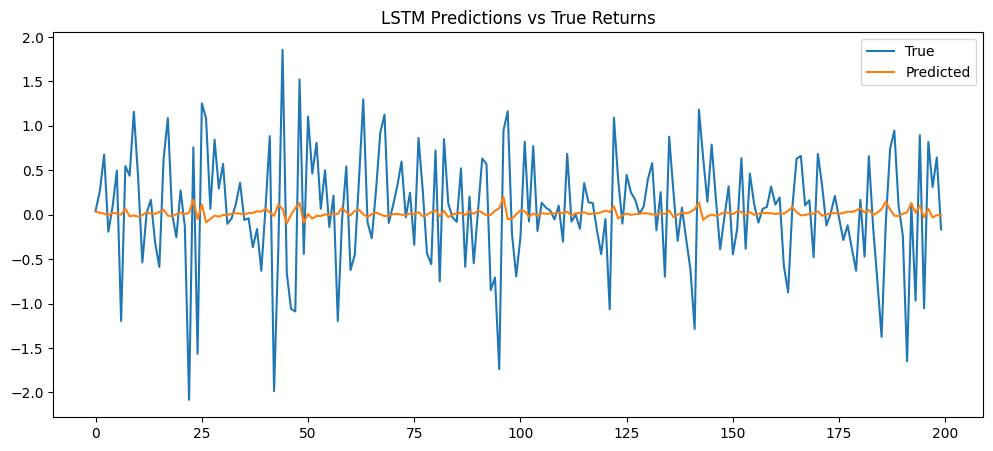

In [24]:
model.eval()

with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()

true_values = y_test_tensor.squeeze().numpy()

plt.figure(figsize =(12,5))
plt.plot(true_values[:200], label="True")
plt.plot(predictions[:200], label="Predicted")
plt.legend()
plt.title("LSTM Predictions vs True Returns")
plt.show()

In [26]:
import numpy as np

corr = np.corrcoef(true_values, predictions)[0,1]
print("Correlation:", corr)


Correlation: 0.06380132044750689
